# Clasificador Binario

## Librerías

In [1]:
!pip install fastai==2.6.3 -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [2]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-19 15:52:04 URL:https://uc6b74fc6d75dd6248b15c70f953.dl.dropboxusercontent.com/cd/0/inline2/Bng24KX-8-fJdmKfdu_cLfBYdU2d7OS6aZm3XOKbuOqxwVbLSXhFZxrU5a9WEc_DKR0vPfQJ1IYQQnMwIPUwu0L4tA6NgmksQO1VGpfWtCnTZ2unU8cQRiWnJV7Tnb4SC1mJ6m3slbk2TtJrZtpnq6sYJJn_kGuH67NgiEMRbls5fQ1DBV57NNrWx4ETr1zgjaWNTCqCFsFeWmTnF9Ijp40_hGtbP13kkfXdANzJ_AWnf9Y3xCKLR9B1mBqlaS2Tom-yHsqDbDshvJBUBLqVrbptzKCZjOG1FHn7o-koizYvxHx1wYLdhNjgYWycf1Uf_QD9F1CjIPUVMPrMyTBn0NwSvxSO0wEXg5dHAOQi22hHzywaAvJtY_v-wqD-vl73pWZBWwAD-LOS9eV9x1vlr5Tjoo6ictJEs14nonWvxoM3XA/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 15:52:10 URL:https://uc61c03f2e7626d4ffad616fd3ec.dl.dropboxusercontent.com/cd/0/inline2/BnhpU6pEVjgPhtksxzKhAHDq9Sx9fSZ38XoHJUxIISHh-48Z_KQbKtl6NdFhPAdActoBkJ2q4bEhG6G-0_set5GdjBOkRdW_sC-mLFurg0ZtUHU6pfVX-LKnxWo9UUwzo2XiIn6yJ8PfjveW3yexAFiQ0y2u91s8p_rJNYw4Sy8Ta6D4CcvPeQc_vJ5nSBtBRqak8TQ6hrGPNh9aX_IoX2KVSoadIhT9q8l28LV2HxpoANDrID_WzgCJ5hSdAnpdQHBQfC3h9TYUFpa7e1pHeaM21Btwe7DYaJ5EoZoYfUyfP_vSBv_fZL3atyUuN4uIzYo

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [7]:
path = Path('dataset/')

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [10]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [11]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [12]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [13]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [14]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [17]:
len(Path('dataset/test/enfermedad').ls()) #401

506

In [19]:
len(Path('dataset/val/normal').ls()) #401

134

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [15]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [16]:
dls = db.dataloaders(path,bs=128)

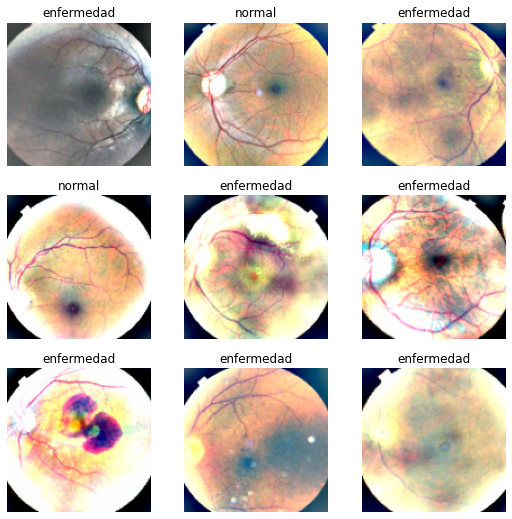

In [17]:
dls.show_batch()

In [18]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [19]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = cnn_learner(dls,resnet18, metrics=metrics, cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=6.309573450380412e-07, valley=0.0012022644514217973, slide=0.007585775572806597)

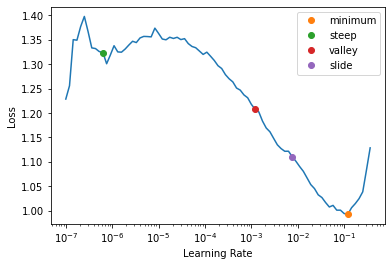

In [20]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,0.579478,0.454788,0.840625,0.590909,0.776119,0.670968,0.159375,00:12


Better model found at epoch 0 with valid_loss value: 0.4547879695892334.


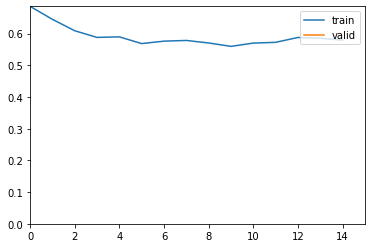

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,0.604498,0.463110,0.831250,0.571429,0.776119,0.658228,0.168750,00:09
1,0.593957,0.462818,0.837500,0.583333,0.783582,0.668790,0.162500,00:08
2,0.585125,0.456613,0.840625,0.589888,0.783582,0.673077,0.159375,00:08
3,0.594773,0.443801,0.857813,0.631902,0.768657,0.693603,0.142188,00:09
4,0.602226,0.443822,0.845312,0.603550,0.761194,0.673267,0.154687,00:09
5,0.596446,0.473984,0.829687,0.567568,0.783582,0.658307,0.170312,00:09
6,0.605614,0.463721,0.835938,0.580110,0.783582,0.666667,0.164062,00:09
7,0.602072,0.472596,0.832812,0.572973,0.791045,0.664577,0.167187,00:09
8,0.603555,0.461527,0.835938,0.580110,0.783582,0.666667,0.164062,00:09
9,0.600235,0.448565,0.848437,0.608187,0.776119,0.681967,0.151562,00:10


Better model found at epoch 0 with valid_loss value: 0.4631097912788391.


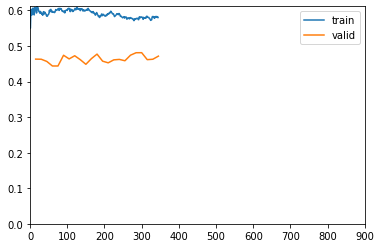

Better model found at epoch 1 with valid_loss value: 0.46281760931015015.
Better model found at epoch 2 with valid_loss value: 0.4566129744052887.
Better model found at epoch 3 with valid_loss value: 0.4438006281852722.
No improvement since epoch 3: early stopping
CPU times: user 1min 1s, sys: 7.84 s, total: 1min 9s
Wall time: 3min 58s


In [28]:
%%time
learn.fine_tune(60,base_lr=1e-5)

Exportamos el modelo

In [29]:
learn.to_fp32()
learn.export('Binario_CEL_resnet18.pkl')

## Evaluando el modelo

In [30]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [31]:
learn.dls = dlsTest

In [32]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6171875.


(#6) [0.6595169901847839,0.6171875,0.32038834951456313,0.7388059701492538,0.44695259593679454,0.3828125]

## Interpretación del modelo

In [33]:
learn.dls=dls

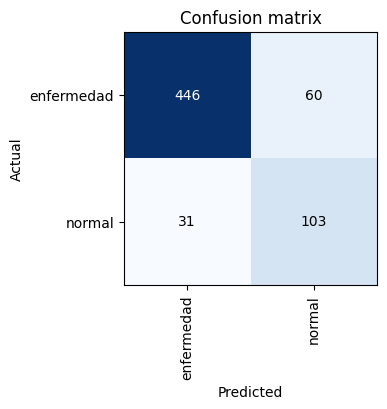

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)